In [1]:
import gzip
import pickle 
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=15)
import numpy as np
import torch 
import dgl
import pandas as pd
import numpy as np
import plotly.express as px
import sys
sys.path.append("/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/")
from sklearn.cluster import DBSCAN
#from torch_scatter import scatter_max, scatter_add, scatter_mean
# from src.layers.inference_oc import get_clustering, obtain_intersection_values
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

/afs/cern.ch/work/m/mgarciam/private/miniconda/miniconda3/envs/graphgps0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
## COMPARING CLD EVENTS TO IDEA EVENTS 1-1

In [23]:
from src.utils.inference.pandas_helpers import open_mlpf_dataframe
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_CLD/models/230724/showers_df_evaluation/0_0_0_2210_4000_6000.pt"
sd_hgb, matched_hgb = open_mlpf_dataframe(path_hgcal, False)

# path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_CLD/models/230724/showers_df_evaluation/0_0_1_test.pt"
# sd_hgb_ct, matched_hgb = open_mlpf_dataframe(path_hgcal, False)



path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_CLD/models/230724/showers_df_evaluation/0_0_0_2210_5000_6000_hdbscan.pt"
sd_hgb_ct, matched_hgb = open_mlpf_dataframe(path_hgcal, False)



path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/180324_Zcard_v_full/showers_df_evaluation/0_0_0_Zjj_5000_6000_v1.pt"
allsd = pd.read_pickle(path_hgcal)
path_hgcal = "/eos/user/m/mgarciam/EVAL_REPOS/Tracking_wcoc/models/180324_Zcard_v_full/showers_df_evaluation/0_0_0Zjj_2810_5000_6000_hdbscan_noseparation.pt"
allsd1 = pd.read_pickle(path_hgcal)


/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/src/utils/inference/pandas_helpers.py:48: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask = (~np.isnan(sd["pred_showers_E"])) * (~np.isnan(sd["reco_showers_E"]))
/afs/cern.ch/work/m/mgarciam/private/Tracking_wcoc/src/utils/inference/pandas_helpers.py:48: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask = (~np.isnan(sd["pred_showers_E"])) * (~np.isnan(sd["reco_showers_E"]))


In [18]:
# import seaborn as sns
# plt.figure(figsize=(4,4))
# sns.histplot(sd_hgb.true_showers_pt, stat="probability", binwidth=1, color="red")
# plt.figure(figsize=(4,4))
# sns.histplot(subset1.true_showers_pt, stat="probability", binwidth=1, color="blue")


In [24]:

mask_R = sd_hgb_ct["R"].values<0.05
mask_number_unique_hits =  sd_hgb_ct["number_unique_hits"].values>3
mask_theta_lower = sd_hgb_ct["theta"].values>(10/180*np.pi)
mask_theta_higher = sd_hgb_ct["theta"].values<(170/180*np.pi)
mask_delta_MC = sd_hgb_ct["delta_MC"].values>0.02
mask_delta_MC_1 = sd_hgb_ct["delta_MC"].values>0
mask_pt = sd_hgb_ct["true_showers_pt"].values>1
mask_gen_status = sd_hgb_ct["gen_status"]==1
total_mask_ct = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_gen_status*mask_number_unique_hits
mask_delta_plot = mask_R*mask_theta_lower*mask_theta_higher*mask_pt*mask_gen_status*mask_number_unique_hits*mask_delta_MC_1
#mask_delta_plot = mask_pt*mask_gen_status*mask_number_unique_hits*mask_delta_MC_1
mask_no_R = mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_pt*mask_gen_status*mask_number_unique_hits
total_mask_ct_all_partices = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_number_unique_hits
print(len(sd_hgb_ct), len( sd_hgb_ct[total_mask_ct]))
reconstructable_ct = sd_hgb_ct[total_mask_ct]
reco_R_ct  = sd_hgb_ct[mask_no_R]
reco_delta_plot = sd_hgb_ct[mask_delta_plot]
reconstructable_ct_all_p = sd_hgb_ct[total_mask_ct_all_partices]
mask_R = sd_hgb["R"].values<0.05
mask_number_unique_hits =  sd_hgb["number_unique_hits"].values>3
mask_theta_lower = sd_hgb["theta"].values>(10/180*np.pi)
mask_theta_higher = sd_hgb["theta"].values<(170/180*np.pi)
mask_delta_MC = sd_hgb["delta_MC"].values>0.02
mask_delta_MC_1 = sd_hgb["delta_MC"].values>0
mask_pt = sd_hgb["true_showers_pt"].values>1
mask_gen_status = sd_hgb["gen_status"]==1
total_mask = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_gen_status*mask_number_unique_hits
mask_delta_plot = mask_R*mask_theta_lower*mask_theta_higher*mask_pt*mask_gen_status*mask_number_unique_hits*mask_delta_MC_1
mask_no_R = mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_pt*mask_gen_status*mask_number_unique_hits
total_mask_all_particles = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_number_unique_hits
print(len(sd_hgb), len(sd_hgb[total_mask]))
reconstructable_ml = sd_hgb[total_mask]
reconstructable_ml_all_p = sd_hgb[total_mask_all_particles]
reco_R_ml   = sd_hgb[mask_no_R]
reco_delta_plot_ml = sd_hgb[mask_delta_plot]

/tmp/mgarciam/ipykernel_677008/1295966252.py:9: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  total_mask_ct = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_gen_status*mask_number_unique_hits
/tmp/mgarciam/ipykernel_677008/1295966252.py:10: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask_delta_plot = mask_R*mask_theta_lower*mask_theta_higher*mask_pt*mask_gen_status*mask_number_unique_hits*mask_delta_MC_1
/tmp/mgarciam/ipykernel_677008/1295966252.py:12: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask_no_R = mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_pt*mask_gen_status*mask_number_unique_hits


3043356 1739629


/tmp/mgarciam/ipykernel_677008/1295966252.py:27: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  total_mask = mask_R*mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_gen_status*mask_number_unique_hits
/tmp/mgarciam/ipykernel_677008/1295966252.py:28: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask_delta_plot = mask_R*mask_theta_lower*mask_theta_higher*mask_pt*mask_gen_status*mask_number_unique_hits*mask_delta_MC_1
/tmp/mgarciam/ipykernel_677008/1295966252.py:29: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  mask_no_R = mask_theta_lower*mask_theta_higher*mask_delta_MC*mask_pt*mask_gen_status*mask_number_unique_hits


6073988 3473102


In [20]:

## CUTS
log = True
# plt.figure()
# mask_reco = allsd.reco_showers_E>15
mask_delta = allsd.delta_MC>0.02
mask_delta_1 = allsd.delta_MC>0
# mask_R = allsd["R"].values/1000<50
# mask_dc_hits = allsd.cdc_hits>4

mask_reco = allsd.reco_showers_E>15
mask_dc_hits = allsd.cdc_hits>2
mask_pt = allsd.true_showers_pt>1
mask_gen_status = allsd.gen_status==1
sd_hgb_ = allsd[mask_reco*mask_delta*mask_dc_hits*mask_gen_status]
sd_hgb_mc = allsd[mask_reco*mask_dc_hits*mask_pt*mask_gen_status*mask_delta_1]
print(len(allsd), len(sd_hgb_))
all_particles_dc = create_eff_dic(sd_hgb_,sd_hgb_,sd_hgb_mc)



## CUTS
log = True
# plt.figure()
# mask_reco = allsd.reco_showers_E>15
mask_delta = allsd1.delta_MC>0.02
mask_delta_1 = allsd1.delta_MC>0
# mask_R = allsd["R"].values/1000<50
# mask_dc_hits = allsd.cdc_hits>4

mask_reco = allsd1.reco_showers_E>15
mask_dc_hits = allsd1.cdc_hits>2
mask_pt = allsd1.true_showers_pt>1
mask_gen_status = allsd1.gen_status==1
sd_hgb_ = allsd1[mask_reco*mask_delta*mask_dc_hits*mask_gen_status]
sd_hgb_mc = allsd1[mask_reco*mask_dc_hits*mask_pt*mask_gen_status*mask_delta_1]
print(len(allsd1), len(sd_hgb_))
all_particles_dc1 = create_eff_dic(sd_hgb_,sd_hgb_,sd_hgb_mc)

/tmp/mgarciam/ipykernel_677008/1587590397.py:14: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  sd_hgb_ = allsd[mask_reco*mask_delta*mask_dc_hits*mask_gen_status]
/tmp/mgarciam/ipykernel_677008/1587590397.py:15: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  sd_hgb_mc = allsd[mask_reco*mask_dc_hits*mask_pt*mask_gen_status*mask_delta_1]


1893146 1153152
0.0010000000000000002 0.0016487212707001285 139 141
0.0016487212707001285 0.0027182818284590456 281 288
0.0027182818284590456 0.004481689070338066 365 380
0.004481689070338066 0.007389056098930652 902 934
0.007389056098930652 0.012182493960703476 2031 2117
0.012182493960703476 0.020085536923187673 5350 5519
0.020085536923187673 0.03311545195869232 13771 14049
0.03311545195869232 0.05459815003314425 33491 33989
0.05459815003314425 0.09001713130052184 68421 69179
0.09001713130052184 0.14841315910257663 103995 104675
0.14841315910257663 0.24469193226422048 113660 114190
0.24469193226422048 0.4034287934927352 89954 90325
0.4034287934927352 0.665141633044362 48946 49153
0.665141633044362 1.096633158428459 17840 17902
1622260 1159543


/tmp/mgarciam/ipykernel_677008/1587590397.py:34: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  sd_hgb_ = allsd1[mask_reco*mask_delta*mask_dc_hits*mask_gen_status]
/tmp/mgarciam/ipykernel_677008/1587590397.py:35: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead.
  sd_hgb_mc = allsd1[mask_reco*mask_dc_hits*mask_pt*mask_gen_status*mask_delta_1]


0.0010000000000000002 0.0016487212707001285 135 137
0.0016487212707001285 0.0027182818284590456 272 280
0.0027182818284590456 0.004481689070338066 368 382
0.004481689070338066 0.007389056098930652 911 946
0.007389056098930652 0.012182493960703476 2131 2226
0.012182493960703476 0.020085536923187673 5602 5790
0.020085536923187673 0.03311545195869232 14219 14561
0.03311545195869232 0.05459815003314425 34229 34850
0.05459815003314425 0.09001713130052184 69204 70148
0.09001713130052184 0.14841315910257663 103823 104670
0.14841315910257663 0.24469193226422048 112682 113287
0.24469193226422048 0.4034287934927352 89030 89421
0.4034287934927352 0.665141633044362 49488 49707
0.665141633044362 1.096633158428459 19330 19405


In [25]:
eff_dict_ct = create_eff_dic(reconstructable_ct,reco_R_ct,reco_delta_plot)
# eff_dict_ct_all_p = create_eff_dic(reconstructable_ct_all_p,reco_R_ct,reco_delta_plot)

0.0010000000000000002 0.0016487212707001285 283 288
0.0016487212707001285 0.0027182818284590456 627 648
0.0027182818284590456 0.004481689070338066 1058 1101
0.004481689070338066 0.007389056098930652 2666 2763
0.007389056098930652 0.012182493960703476 6656 6799
0.012182493960703476 0.020085536923187673 17038 17345
0.020085536923187673 0.03311545195869232 42462 42944
0.03311545195869232 0.05459815003314425 94180 94895
0.05459815003314425 0.09001713130052184 161782 162769
0.09001713130052184 0.14841315910257663 198249 199245
0.14841315910257663 0.24469193226422048 175477 176332
0.24469193226422048 0.4034287934927352 111693 112029
0.4034287934927352 0.665141633044362 45972 46103
0.665141633044362 1.096633158428459 12475 12497


In [26]:
eff_dict_ml = create_eff_dic(reconstructable_ml,reco_R_ml,reco_delta_plot_ml)
# eff_dict_ml_all_p = create_eff_dic(reconstructable_ml_all_p,reco_R_ml,reco_delta_plot_ml)

0.0010000000000000002 0.0016487212707001285 568 581
0.0016487212707001285 0.0027182818284590456 1232 1274
0.0027182818284590456 0.004481689070338066 2172 2254
0.004481689070338066 0.007389056098930652 5177 5344
0.007389056098930652 0.012182493960703476 13206 13520
0.012182493960703476 0.020085536923187673 34278 34895
0.020085536923187673 0.03311545195869232 84615 85588
0.03311545195869232 0.05459815003314425 187874 189326
0.05459815003314425 0.09001713130052184 322910 324798
0.09001713130052184 0.14841315910257663 396907 398894
0.14841315910257663 0.24469193226422048 351261 352870
0.24469193226422048 0.4034287934927352 222319 223046
0.4034287934927352 0.665141633044362 92581 92843
0.665141633044362 1.096633158428459 25031 25068


In [13]:
def limit_error_bars(y, yerr, upper_limit=1):
    yerr_upper = np.minimum(y + yerr, upper_limit) - y
    yerr_lower = yerr  # Lower error bars remain unchanged
    return yerr_lower, yerr_upper


In [72]:
# import seaborn
# fig = plt.figure(figsize=(4,4))
# axs = fig.add_subplot(111)
# seaborn.histplot(sd_hgb_mc.delta_MC)
# plt.xscale("log")
# axs.axvline(x=0.02, linestyle='--')

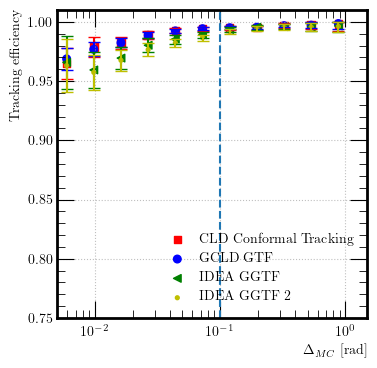

In [27]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
fig= plt.figure( figsize=(4, 4))
ax = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b", "g", "y"]
marker = ["s", "o", "<", "."]
labels = ["CLD Conformal Tracking", "GCLD GTF", "IDEA GGTF", "IDEA GGTF 2"]
dataframe_list = [eff_dict_ct,eff_dict_ml,   all_particles_dc, all_particles_dc1]
i =0 
log = True
plt.xlabel(r"$\Delta_{MC}$ [rad]")
plt.ylabel("Tracking efficiency")

for i in range(0, len(dataframe_list)):
    plt.scatter(
        np.array(dataframe_list[i]["delta_MC_values"]),
        np.array(dataframe_list[i]["eff_delta_MC"]),
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff_delta_MC"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors_delta_mc"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff_delta_MC"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["delta_MC_values"], dataframe_list[i]["eff_delta_MC"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)


# plt.title("CLD")
plt.legend(loc="lower right") #title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r'$10< \theta< 170$,' "\n" r"$p_T>1 \textrm{ GeV}, \textrm{vertex } R>50 \textrm{ mm}$")
plt.xscale("log")
# ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
# ax.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.grid(which='major', linestyle=':', linewidth='0.5', color='black')
# ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.grid(True)
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
plt.xlim([5*1e-3,1.5])
plt.ylim([0.75,1.01])
ax.axvline(x=0.1, linestyle='--')
size_font=10
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10
leg = ax.get_legend()
leg._legend_box.align = "left"

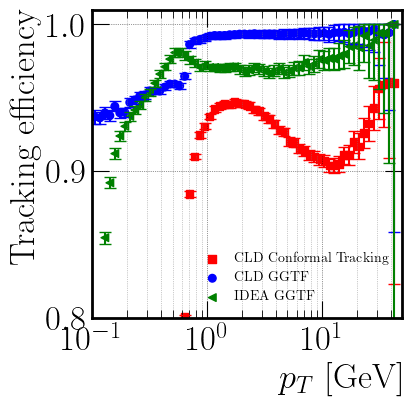

In [22]:
def limit_error_bars(y, yerr, upper_limit=1):
    yerr_upper = np.minimum(y + yerr, upper_limit) - y
    yerr_lower = yerr  # Lower error bars remain unchanged
    return yerr_lower, yerr_upper
fig= plt.figure( figsize=(4, 4))
axs = fig.add_subplot(111)
colors_list = ["#FF0000", "#FF0000", "#0000FF"]
index = 0
j = 0
colors = ["r", "b", "g"]
marker = ["s", "o", "<"]
labels = ["CLD Conformal Tracking", "CLD GGTF", "IDEA GGTF"]
dataframe_list = [eff_dict_ct, eff_dict_ml, all_particles_dc]
i =0 
plot_title =""
log = True
plt.xlabel("$p_T$ [GeV]")
plt.ylabel("Tracking efficiency")

for i in range(0, len(dataframe_list)):
    axs.scatter(
        dataframe_list[i]["energy_eff"],
        dataframe_list[i]["eff"],
        label=labels[i] ,
        marker=marker[i],
        c = [colors[i] for j in range(0,len(dataframe_list[i]["eff"]))],
        s=30,
    )
    error_y = dataframe_list[i]["errors"]
    yerr_lower, yerr_upper = limit_error_bars(np.array(dataframe_list[i]["eff"]), np.array(error_y)/2, upper_limit=1)
    plt.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["eff"] ,yerr= [yerr_lower, yerr_upper], ecolor=colors[i], linestyle='none', capsize=4)

    # axs.errorbar(dataframe_list[i]["energy_eff"], dataframe_list[i]["eff"] , xerr=dataframe_list[i]["size_energy_bin"]/2,yerr= dataframe_list[i]["errors"], linestyle='none')

if log:
    log_ = "log"
    axs.set_xscale("log")
else:
    log_ = ""
axs.set_ylim([0.7, 1.01])
# axs.legend(loc="lower left")

# axs.axvline(x=0.7, linestyle='--')

plt.legend(loc="lower right") #title=r'$Z/\gamma^* \rightarrow q \bar q (q=u,d)$' "\n" r"$\Delta_{MC}>0.02 \textrm{ rad}$")

axs.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=4))
axs.xaxis.set_minor_locator(plt.LogLocator(base=10.0, subs='auto', numticks=10))
axs.yaxis.set_major_locator(plt.MultipleLocator(0.1))
axs.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
axs.grid(which='major', linestyle=':', linewidth='0.5', color='black')
axs.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.xlim([1e-1,50])
plt.ylim([0.8,1.01])
plt.rc("text", usetex=True)
plt.rc("font", family="serif")
size_font = 25
plt.rcParams['font.size'] = size_font
plt.rcParams['axes.labelsize'] = size_font
plt.rcParams['xtick.labelsize'] = size_font
plt.rcParams['ytick.labelsize'] = size_font
plt.rcParams['legend.fontsize'] = 10

# leg._legend_box.align = "right"

In [48]:
len(dataframe_list[1]["errors_delta_mc"]),len(dataframe_list[1]["eff_delta_MC"])

(39, 39)

In [5]:

def create_eff_dic(matched_, reco_r,reco_delta):
    df_id = matched_
    photons_dic = calculate_eff(df_id)
    photons_dic = calculate_eff_vertex(reco_r,photons_dic)
    photons_dic = calculate_eff_DeltaMC(reco_delta,photons_dic)
    return photons_dic


def calculate_eff(sd, log_scale=False):
    # if log_scale:
    bins = np.exp(np.arange(np.log(1e-1), np.log(50), 0.1))
    # else:
    #     bins = np.arange(0, 51, 2)
    #bins = [5e-3,0.1,1.80804241e-01,2.98095799e-01, 4.91476884e-01, 8.10308393e-01, 1.33597268e+00,2.20264658e+00, 3.63155027e+00, 5.98741417e+00, 9.87157710e+00,1.62754791e+01, 2.68337287e+01, 4.42413392e+01]
    bins = np.array(bins)
    eff = []
    eff_50 = []
    eff_75 = []
    energy_eff = []
    size_energy_bin = []
    errors = []
    number_of_hits = []
    number_of_hits_var = []
    total_showers_ = []
    purity = []
    purity_var = []
    number_of_hits_unique = []
    number_of_hits_var_unique = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.true_showers_pt.values <= bin_i1
        mask_below = sd.true_showers_pt.values > bin_i
        # this mask takes all E that have values (does not include fakes then)
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        mask_non_nan = ~np.isnan(sd.e_pred_and_truth.values)
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            #total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>3)
            particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            more_than_4_hits = sd["pred_showers_E"][mask].values>3
            total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>5)
            # total_reconstructed_cld_crit =  np.sum((track_purity>=0.75)*more_than_4_hits)
            total_reconstructed_cld_crit =  np.sum((particle_purity>=0.4)*(track_purity>=0.4)*more_than_4_hits)
      

            # print(total_reconstructed_cld_crit,total_showers )
            percentage_of_hits_MC = sd["e_pred_and_truth"][mask*mask_non_nan].values/sd["reco_showers_E"][mask*mask_non_nan].values
            percentage_of_hits_MC_unique = sd["number_unique_hits_reconstructed"][mask*mask_non_nan].values/sd["number_unique_hits"][mask*mask_non_nan].values
            purity_list =  sd["e_pred_and_truth"][mask*mask_non_nan].values/sd["pred_showers_E"][mask*mask_non_nan].values
            n_t_purity =  sd["e_pred_and_truth"][mask*mask_non_nan].values
            n_f = sd["pred_showers_E"][mask*mask_non_nan].values-n_t_purity
            sigma_t_purity = np.var(n_t_purity)
            sigma_f_purity = np.var(n_f)
            error_purity = (n_f/(n_t_purity+n_f)**2*sigma_t_purity)**2+(n_t_purity*sigma_f_purity/(n_t_purity+n_f)**2)**2
            N = len(error_purity)
            purity.append(np.mean(purity_list))
            purity_var.append(1/N*(np.sqrt(np.sum(error_purity))))
            number_of_hits.append(np.mean(percentage_of_hits_MC))
            number_of_hits_unique.append(np.mean(percentage_of_hits_MC_unique))

            n_r = sd["e_pred_and_truth"][mask*mask_non_nan].values
            n_t = sd["reco_showers_E"][mask*mask_non_nan].values
            error_percentage_of_hits = (n_r/(n_t**2)*np.sqrt(n_t))**2+(1/n_t*np.sqrt(n_r))**2
            N = len(error_percentage_of_hits)
            number_of_hits_var.append(1/N*np.sqrt(np.sum(error_percentage_of_hits)))

            n_r = sd["number_unique_hits_reconstructed"][mask*mask_non_nan].values
            n_t = sd["number_unique_hits"][mask*mask_non_nan].values
            N = len(error_percentage_of_hits)
            error_percentage_of_hits_unique = (n_r/(n_t**2)*np.sqrt(n_t))**2+(1/n_t*np.sqrt(n_r))**2
            number_of_hits_var_unique.append(1/N*np.sqrt(np.sum(error_percentage_of_hits_unique)))
            total_reconstructed_50 = np.sum(percentage_of_hits_MC>0.50)
            total_reconstructed_75 = np.sum(percentage_of_hits_MC>0.75)
            eff.append(
                (total_reconstructed_cld_crit) / total_showers
            )
            eff_50.append(total_reconstructed_50/total_showers)
            eff_75.append(total_reconstructed_75/total_showers)
            energy_eff.append((bin_i1 + bin_i) / 2)
            size_energy_bin.append((bin_i1-bin_i)/2)
            total_showers_.append(total_showers)
            n_total = total_showers
            n_r = total_reconstructed_cld_crit
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors.append(error)
        # print(
        #     "bin",
        #     bin_i1,
        #     bin_i,
        #     (total_showers - number_of_non_reconstructed_showers) / total_showers,
        #     total_showers,
        #     (total_showers - number_of_non_reconstructed_showers),
        #     error
        # )
    photons_dic = {}
    photons_dic["purity"]= purity
    photons_dic["number_of_hits_unique"]= number_of_hits_unique
    photons_dic["purity_var"]=purity_var
    # photons_dic["eff_50"] = eff_50
    # photons_dic["eff_75"] = eff_75
    photons_dic["eff"] = eff
    photons_dic["number_of_hits"]=number_of_hits
    photons_dic["number_of_hits_var"]= number_of_hits_var
    photons_dic["number_of_hits_var_unique"] = number_of_hits_var_unique
    photons_dic["energy_eff"] = energy_eff
    photons_dic["total_showers_"] = total_showers_
    photons_dic["size_energy_bin"] = size_energy_bin
    photons_dic["errors"] = errors
    return photons_dic


In [6]:
np.arccos(0.99)/np.pi*180

8.109614455994183

In [7]:
def calculate_eff_vertex(sd,photons_dic):
    # if log_scale:
   
    # else:
    bins = np.arange(0, 1000, 20)
    bins = np.array(bins)
    eff_v = []
    energy_v = []
    errors_v = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = (sd.R.values*1000) <= bin_i1
        mask_below = (sd.R.values*1000) > bin_i
        mask = mask_below * mask_above

        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            # purity_calc = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            # more_than_4_hits = sd["pred_showers_E"][mask].values>3
            # total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>3)
            # particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            # track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            # more_than_4_hits = sd["pred_showers_E"][mask].values>3
            #total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            # total_reconstructed_cld_crit =  np.sum((particle_purity>=0.5)*(track_purity>=0.5)*more_than_4_hits)
            eff_v.append(
                (total_reconstructed_cld_crit) / total_showers
            )
            energy_v.append((bin_i1 + bin_i) / 2)
        
            n_total = total_showers
            n_r = total_reconstructed_cld_crit
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors_v.append(error)

    photons_dic["eff_v"]= eff_v
    photons_dic["energy_v"]=energy_v
    photons_dic["errors_v"] =errors_v

    return photons_dic


In [8]:
 np.exp(np.arange(np.log(1e-3), np.log(0.5), 0.5))

array([0.001     , 0.00164872, 0.00271828, 0.00448169, 0.00738906,
       0.01218249, 0.02008554, 0.03311545, 0.05459815, 0.09001713,
       0.14841316, 0.24469193, 0.40342879])

In [9]:

def calculate_eff_DeltaMC(sd, photons, dictlog_scale=False):
    
    bins = np.arange(0.001, 0.4,0.01)
    bins = np.exp(np.arange(np.log(1e-3), np.log(1.5), 0.5))
    eff = []
    energy_eff = []
    total_showers_ = []
    errors_delta_mc = []
    for i in range(len(bins) - 1):
        bin_i = bins[i]
        bin_i1 = bins[i + 1]
        mask_above = sd.delta_MC.values <= bin_i1
        mask_below = sd.delta_MC.values > bin_i
        mask = mask_below * mask_above
        number_of_non_reconstructed_showers = np.sum(
            np.isnan(sd.pred_showers_E.values)[mask]
        )
        total_showers = len(sd.pred_showers_E.values[mask])
        if total_showers > 0:
            # purity_calc = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            # more_than_4_hits = sd["pred_showers_E"][mask].values>3
            # total_reconstructed_cld_crit =  np.sum((purity_calc>=0.75)*more_than_4_hits)
            total_reconstructed_cld_crit = np.sum(sd["e_pred_and_truth"][mask].values>3)
            # particle_purity = sd["e_pred_and_truth"][mask].values/sd["reco_showers_E"][mask].values
            # track_purity = sd["e_pred_and_truth"][mask].values/sd["pred_showers_E"][mask].values
            # more_than_4_hits = sd["pred_showers_E"][mask].values>3
            # total_reconstructed_cld_crit =  np.sum((particle_purity>=0.5)*(track_purity>=0.5)*more_than_4_hits)
            print(bin_i, bin_i1, total_reconstructed_cld_crit, total_showers)
            eff.append(
                (total_reconstructed_cld_crit) / total_showers
            )
            energy_eff.append((bin_i1 + bin_i) / 2)
            total_showers_.append(total_showers)
            n_total = total_showers
            n_r = total_reconstructed_cld_crit
            error = (n_r/(n_total**2)*np.sqrt(n_total))**2+(1/n_total*np.sqrt(n_r))**2
            error = np.sqrt(error)
            errors_delta_mc.append(error)
    photons["eff_delta_MC"]= eff
    photons["delta_MC_values"]=energy_eff
    photons["errors_delta_mc"]=errors_delta_mc
    return photons